In [1]:
!pip install numpy pandas tensorflow scikit-learn matplotlib seaborn plotly astropy lightkurve gradio ipywidgets h5py joblib tqdm umap-learn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers, models, optimizers, losses, callbacks
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, f1_score
import umap
import gradio as gr
import pickle

In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def generate_transit_curve():
    time = np.linspace(0, 30, 1000)
    flux = np.ones_like(time)
    start = np.random.randint(200, 800)
    depth = np.random.uniform(0.005, 0.02)
    duration = np.random.randint(30, 80)
    flux[start:start+duration] -= depth
    flux += np.random.normal(0, 0.0002, size=flux.shape)
    return time, flux

def generate_no_transit_curve():
    time = np.linspace(0, 30, 1000)
    flux = np.ones_like(time)
    flux += np.random.normal(0, 0.0002, size=flux.shape)
    return time, flux

def generate_false_positive_curve():
    time = np.linspace(0, 30, 1000)
    flux = np.ones_like(time)
    for _ in range(np.random.randint(1, 2)):
        idx = np.random.randint(0, 1000)
        flux[idx] -= np.random.uniform(0.002, 0.01)
    flux += np.random.normal(0, 0.0002, size=flux.shape)
    return time, flux

In [5]:
X = []
y_class = []
y_radius = []
y_duration = []
y_period = []

for _ in range(150000):
    choice = np.random.choice(["transit", "no_transit", "false_positive"])
    if choice == "transit":
        time, flux = generate_transit_curve()
        label = 1
        radius = np.random.uniform(0.5, 2.0)
        duration = np.random.uniform(1, 10)
        period = np.random.uniform(2, 20)
    elif choice == "no_transit":
        time, flux = generate_no_transit_curve()
        label = 0
        radius = 0.0
        duration = 0.0
        period = 0.0
    else:
        time, flux = generate_false_positive_curve()
        label = 2
        radius = 0.0
        duration = 0.0
        period = 0.0

    X.append(flux)
    y_class.append(label)
    y_radius.append(radius)
    y_duration.append(duration)
    y_period.append(period)

X = np.array(X)
y_class = np.array(y_class)
y_radius = np.array(y_radius)
y_duration = np.array(y_duration)
y_period = np.array(y_period)

In [6]:
df = pd.DataFrame(X, columns=[f"flux_{i}" for i in range(1000)])
df["class"] = y_class
df["radius"] = y_radius
df["duration"] = y_duration
df["period"] = y_period
df.to_csv("generated_light_curves.csv", index=False)
print("generated_light_curves.csv'")

generated_light_curves.csv'


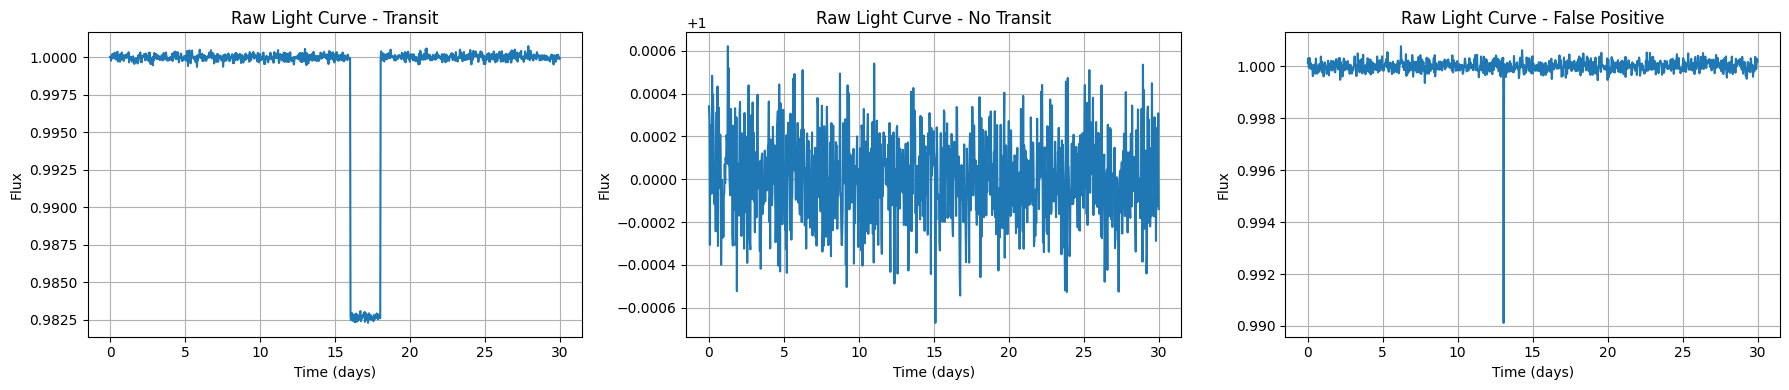

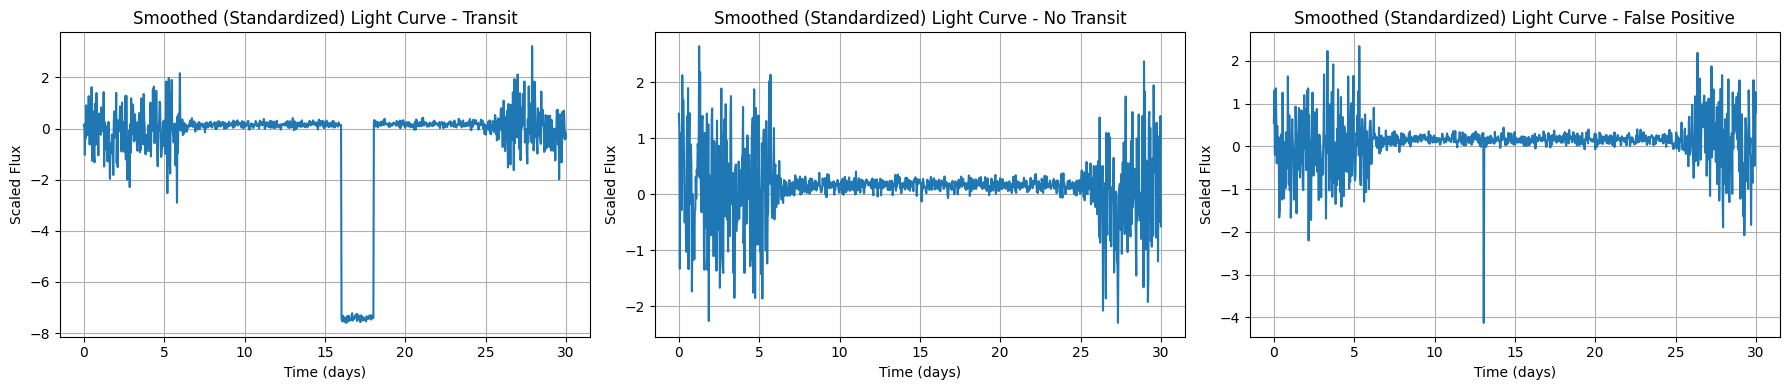

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sample_indices = [np.where(y_class == 1)[0][0], np.where(y_class == 0)[0][0], np.where(y_class == 2)[0][0]]
titles = ["Transit", "No Transit", "False Positive"]
time = np.linspace(0, 30, 1000)

plt.figure(figsize=(18, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(time, X[idx])
    plt.title(f"Raw Light Curve - {titles[i]}")
    plt.xlabel('Time (days)')
    plt.ylabel('Flux')
    plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(time, X_scaled[idx])
    plt.title(f"Smoothed (Standardized) Light Curve - {titles[i]}")
    plt.xlabel('Time (days)')
    plt.ylabel('Scaled Flux')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
with open('flux_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

X = X_scaled
print("flux_scaler.pkl")

flux_scaler.pkl


In [9]:
X_train, X_test, y_train_cls, y_test_cls, y_train_r, y_test_r, y_train_d, y_test_d, y_train_p, y_test_p = train_test_split(
    X, y_class, y_radius, y_duration, y_period, test_size=0.2, stratify=y_class, random_state=42
)

print("Train/Test split completed.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Train/Test split completed.
Training samples: 120000
Testing samples: 30000


In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

input_layer = layers.Input(shape=(1000,))
x = layers.Reshape((1000, 1))(input_layer)

for _ in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output_class = layers.Dense(3, activation='softmax', name='class_output')(x)
output_radius = layers.Dense(1, activation='linear', name='radius_output')(x)
output_duration = layers.Dense(1, activation='linear', name='duration_output')(x)
output_period = layers.Dense(1, activation='linear', name='period_output')(x)

model = models.Model(inputs=input_layer, outputs=[output_class, output_radius, output_duration, output_period])

In [11]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.1)
        probs = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_factor = tf.pow(1. - probs, gamma)
        loss = alpha * focal_factor * cross_entropy
        return loss
    return focal_loss_fixed

In [12]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss={
        'class_output': focal_loss(),
        'radius_output': 'mse',
        'duration_output': 'mse',
        'period_output': 'mse'
    },
    metrics={
        'class_output': 'accuracy',
        'radius_output': 'mae',
        'duration_output': 'mae',
        'period_output': 'mae'
    }
)

In [13]:
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

In [14]:
history = model.fit(
    X_train,
    {
        'class_output': tf.keras.utils.to_categorical(y_train_cls, num_classes=3),
        'radius_output': y_train_r,
        'duration_output': y_train_d,
        'period_output': y_train_p
    },
    validation_data=(
        X_test,
        {
            'class_output': tf.keras.utils.to_categorical(y_test_cls, num_classes=3),
            'radius_output': y_test_r,
            'duration_output': y_test_d,
            'period_output': y_test_p
        }
    ),
    epochs=25,
    batch_size=64,
    callbacks=[lr_schedule, early_stop, model_checkpoint]
)

Epoch 1/25
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.4963 - class_output_loss: 0.0971 - duration_output_loss: 6.9477 - duration_output_mae: 1.9285 - loss: 35.6706 - period_output_loss: 28.3204 - period_output_mae: 3.9037 - radius_output_loss: 0.3054 - radius_output_mae: 0.4138
Epoch 1: val_loss improved from inf to 17.09415, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 110s 49ms/step - class_output_accuracy: 0.4964 - class_output_loss: 0.0971 - duration_output_loss: 6.9456 - duration_output_mae: 1.9281 - loss: 35.6602 - period_output_loss: 28.3121 - period_output_mae: 3.9029 - radius_output_loss: 0.3053 - radius_output_mae: 0.4137 - val_class_output_accuracy: 0.7047 - val_class_output_loss: 0.0374 - val_duration_output_loss: 3.2993 - val_duration_output_mae: 1.1232 - val_loss: 17.0942 - val_period_output_loss: 13.6522 - val_period_output_mae: 2.3396 - val_radius_output_loss: 0.1069 - val_radius_output_mae: 0.2087 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7125 - class_output_loss: 0.0385 - duration_output_loss: 3.3683 - duration_output_mae: 1.2150 - loss: 17.0551 - period_output_loss: 13.5337 - period_output_mae: 2.3947 - radius_output_loss: 0.1146 - radius_output_mae: 0.2408
Epoch 2: val_loss improved from 17.09415 to 14.94209, saving model to best_model.h5

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - class_output_accuracy: 0.7125 - class_output_loss: 0.0385 - duration_output_loss: 3.3683 - duration_output_mae: 1.2150 - loss: 17.0549 - period_output_loss: 13.5335 - period_output_mae: 2.3948 - radius_output_loss: 0.1146 - radius_output_mae: 0.2408 - val_class_output_accuracy: 0.7333 - val_class_output_loss: 0.0366 - val_duration_output_loss: 2.9017 - val_duration_output_mae: 1.0414 - val_loss: 14.9421 - val_period_output_loss: 11.9147 - val_period_output_mae: 2.1244 - val_radius_output_loss: 0.0904 - val_radius_output_mae: 0.1809 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7137 - class_output_loss: 0.0381 - duration_output_loss: 3.2089 - duration_output_mae: 1.2652 - loss: 16.1032 - period_output_loss: 12.7480 - period_output_mae: 2.4890 - radius_output_loss: 0.1082 - radius_output_mae: 0.2463
Epoch 3: val_loss improved from 14.94209 to 14.31029, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7137 - class_output_loss: 0.0381 - duration_output_loss: 3.2089 - duration_output_mae: 1.2652 - loss: 16.1032 - period_output_loss: 12.7480 - period_output_mae: 2.4891 - radius_output_loss: 0.1082 - radius_output_mae: 0.2463 - val_class_output_accuracy: 0.7197 - val_class_output_loss: 0.0361 - val_duration_output_loss: 2.7682 - val_duration_output_mae: 1.0315 - val_loss: 14.3103 - val_period_output_loss: 11.4232 - val_period_output_mae: 2.1312 - val_radius_output_loss: 0.0840 - val_radius_output_mae: 0.1792 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7162 - class_output_loss: 0.0379 - duration_output_loss: 3.1613 - duration_output_mae: 1.2693 - loss: 15.8931 - period_output_loss: 12.5868 - period_output_mae: 2.5092 - radius_output_loss: 0.1071 - radius_output_mae: 0.2459
Epoch 4: val_loss improved from 14.31029 to 14.09980, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7162 - class_output_loss: 0.0379 - duration_output_loss: 3.1613 - duration_output_mae: 1.2693 - loss: 15.8930 - period_output_loss: 12.5868 - period_output_mae: 2.5091 - radius_output_loss: 0.1071 - radius_output_mae: 0.2459 - val_class_output_accuracy: 0.7178 - val_class_output_loss: 0.0359 - val_duration_output_loss: 2.7206 - val_duration_output_mae: 1.0160 - val_loss: 14.0998 - val_period_output_loss: 11.2614 - val_period_output_mae: 2.1172 - val_radius_output_loss: 0.0833 - val_radius_output_mae: 0.1800 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7230 - class_output_loss: 0.0374 - duration_output_loss: 3.1280 - duration_output_mae: 1.2580 - loss: 15.7144 - period_output_loss: 12.4428 - period_output_mae: 2.4876 - radius_output_loss: 0.1062 - radius_output_mae: 0.2429
Epoch 5: val_loss improved from 14.09980 to 13.88135, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7230 - class_output_loss: 0.0374 - duration_output_loss: 3.1280 - duration_output_mae: 1.2580 - loss: 15.7143 - period_output_loss: 12.4427 - period_output_mae: 2.4876 - radius_output_loss: 0.1062 - radius_output_mae: 0.2429 - val_class_output_accuracy: 0.7216 - val_class_output_loss: 0.0357 - val_duration_output_loss: 2.6815 - val_duration_output_mae: 0.9835 - val_loss: 13.8813 - val_period_output_loss: 11.0828 - val_period_output_mae: 2.0345 - val_radius_output_loss: 0.0827 - val_radius_output_mae: 0.1767 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7262 - class_output_loss: 0.0369 - duration_output_loss: 3.0771 - duration_output_mae: 1.2388 - loss: 15.5212 - period_output_loss: 12.3034 - period_output_mae: 2.4620 - radius_output_loss: 0.1039 - radius_output_mae: 0.2394
Epoch 6: val_loss improved from 13.88135 to 13.64569, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7262 - class_output_loss: 0.0369 - duration_output_loss: 3.0771 - duration_output_mae: 1.2388 - loss: 15.5212 - period_output_loss: 12.3033 - period_output_mae: 2.4620 - radius_output_loss: 0.1039 - radius_output_mae: 0.2394 - val_class_output_accuracy: 0.7291 - val_class_output_loss: 0.0355 - val_duration_output_loss: 2.6427 - val_duration_output_mae: 0.9391 - val_loss: 13.6457 - val_period_output_loss: 10.8869 - val_period_output_mae: 1.9495 - val_radius_output_loss: 0.0818 - val_radius_output_mae: 0.1700 - learning_rate: 0.0010
Epoch 7/25
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7248 - class_output_loss: 0.0366 - duration_output_loss: 3.0662 - duration_output_mae: 1.2351 - loss: 15.3450 - period_output_loss: 12.1384 - period_output_mae: 2.4436 - radius_output_loss: 0.1038 - radius_output_mae: 0.2391
Epoch 7: val_loss did not improve from 13.64569
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 4

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7274 - class_output_loss: 0.0365 - duration_output_loss: 3.0638 - duration_output_mae: 1.2297 - loss: 15.3183 - period_output_loss: 12.1150 - period_output_mae: 2.4316 - radius_output_loss: 0.1030 - radius_output_mae: 0.2380 - val_class_output_accuracy: 0.7268 - val_class_output_loss: 0.0350 - val_duration_output_loss: 2.6598 - val_duration_output_mae: 0.9461 - val_loss: 13.6158 - val_period_output_loss: 10.8391 - val_period_output_mae: 1.9266 - val_radius_output_loss: 0.0830 - val_radius_output_mae: 0.1723 - learning_rate: 0.0010
Epoch 9/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7267 - class_output_loss: 0.0363 - duration_output_loss: 3.0609 - duration_output_mae: 1.2274 - loss: 15.2883 - period_output_loss: 12.0876 - period_output_mae: 2.4265 - radius_output_loss: 0.1034 - radius_output_mae: 0.2384
Epoch 9: val_loss improved from 13.61577 to 13.52226, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7267 - class_output_loss: 0.0363 - duration_output_loss: 3.0609 - duration_output_mae: 1.2274 - loss: 15.2883 - period_output_loss: 12.0876 - period_output_mae: 2.4265 - radius_output_loss: 0.1034 - radius_output_mae: 0.2384 - val_class_output_accuracy: 0.7309 - val_class_output_loss: 0.0351 - val_duration_output_loss: 2.6409 - val_duration_output_mae: 0.9377 - val_loss: 13.5223 - val_period_output_loss: 10.7655 - val_period_output_mae: 1.8923 - val_radius_output_loss: 0.0820 - val_radius_output_mae: 0.1695 - learning_rate: 0.0010
Epoch 10/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7269 - class_output_loss: 0.0361 - duration_output_loss: 3.0359 - duration_output_mae: 1.2200 - loss: 15.2104 - period_output_loss: 12.0366 - period_output_mae: 2.4156 - radius_output_loss: 0.1019 - radius_output_mae: 0.2353
Epoch 10: val_loss improved from 13.52226 to 13.51788, saving model to best_model.h

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - class_output_accuracy: 0.7269 - class_output_loss: 0.0361 - duration_output_loss: 3.0359 - duration_output_mae: 1.2200 - loss: 15.2104 - period_output_loss: 12.0366 - period_output_mae: 2.4156 - radius_output_loss: 0.1019 - radius_output_mae: 0.2353 - val_class_output_accuracy: 0.7173 - val_class_output_loss: 0.0351 - val_duration_output_loss: 2.6426 - val_duration_output_mae: 0.9528 - val_loss: 13.5179 - val_period_output_loss: 10.7595 - val_period_output_mae: 1.9226 - val_radius_output_loss: 0.0819 - val_radius_output_mae: 0.1718 - learning_rate: 0.0010
Epoch 11/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7258 - class_output_loss: 0.0360 - duration_output_loss: 3.0386 - duration_output_mae: 1.2174 - loss: 15.2330 - period_output_loss: 12.0570 - period_output_mae: 2.4135 - radius_output_loss: 0.1014 - radius_output_mae: 0.2349
Epoch 11: val_loss did not improve from 13.51788
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7273 - class_output_loss: 0.0360 - duration_output_loss: 3.0197 - duration_output_mae: 1.2120 - loss: 15.1350 - period_output_loss: 11.9780 - period_output_mae: 2.4006 - radius_output_loss: 0.1013 - radius_output_mae: 0.2348 - val_class_output_accuracy: 0.7328 - val_class_output_loss: 0.0350 - val_duration_output_loss: 2.6186 - val_duration_output_mae: 0.9466 - val_loss: 13.3960 - val_period_output_loss: 10.6626 - val_period_output_mae: 1.9003 - val_radius_output_loss: 0.0809 - val_radius_output_mae: 0.1715 - learning_rate: 0.0010
Epoch 13/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - class_output_accuracy: 0.7290 - class_output_loss: 0.0359 - duration_output_loss: 3.0164 - duration_output_mae: 1.2118 - loss: 15.0517 - period_output_loss: 11.8991 - period_output_mae: 2.3939 - radius_output_loss: 0.1003 - radius_output_mae: 0.2337
Epoch 13: val_loss improved from 13.39604 to 13.32931, saving model to best_model.h

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7290 - class_output_loss: 0.0359 - duration_output_loss: 3.0164 - duration_output_mae: 1.2118 - loss: 15.0516 - period_output_loss: 11.8991 - period_output_mae: 2.3939 - radius_output_loss: 0.1003 - radius_output_mae: 0.2337 - val_class_output_accuracy: 0.7382 - val_class_output_loss: 0.0350 - val_duration_output_loss: 2.6087 - val_duration_output_mae: 0.9025 - val_loss: 13.3293 - val_period_output_loss: 10.6059 - val_period_output_mae: 1.8033 - val_radius_output_loss: 0.0807 - val_radius_output_mae: 0.1613 - learning_rate: 0.0010
Epoch 14/25
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7291 - class_output_loss: 0.0358 - duration_output_loss: 3.0051 - duration_output_mae: 1.2094 - loss: 14.9977 - period_output_loss: 11.8569 - period_output_mae: 2.3876 - radius_output_loss: 0.0999 - radius_output_mae: 0.2335
Epoch 14: val_loss did not improve from 13.32931
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7282 - class_output_loss: 0.0358 - duration_output_loss: 3.0053 - duration_output_mae: 1.2105 - loss: 14.9982 - period_output_loss: 11.8565 - period_output_mae: 2.3859 - radius_output_loss: 0.1005 - radius_output_mae: 0.2342 - val_class_output_accuracy: 0.7368 - val_class_output_loss: 0.0348 - val_duration_output_loss: 2.6039 - val_duration_output_mae: 0.9154 - val_loss: 13.3074 - val_period_output_loss: 10.5888 - val_period_output_mae: 1.8296 - val_radius_output_loss: 0.0810 - val_radius_output_mae: 0.1682 - learning_rate: 0.0010
Epoch 16/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7292 - class_output_loss: 0.0358 - duration_output_loss: 2.9883 - duration_output_mae: 1.2070 - loss: 14.9510 - period_output_loss: 11.8270 - period_output_mae: 2.3792 - radius_output_loss: 0.0999 - radius_output_mae: 0.2331
Epoch 16: val_loss did not improve from 13.30740
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7308 - class_output_loss: 0.0354 - duration_output_loss: 2.9804 - duration_output_mae: 1.2056 - loss: 14.9046 - period_output_loss: 11.7897 - period_output_mae: 2.3759 - radius_output_loss: 0.0991 - radius_output_mae: 0.2320 - val_class_output_accuracy: 0.7411 - val_class_output_loss: 0.0344 - val_duration_output_loss: 2.6022 - val_duration_output_mae: 0.9168 - val_loss: 13.3001 - val_period_output_loss: 10.5844 - val_period_output_mae: 1.8336 - val_radius_output_loss: 0.0803 - val_radius_output_mae: 0.1666 - learning_rate: 5.0000e-04
Epoch 23/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7336 - class_output_loss: 0.0354 - duration_output_loss: 2.9838 - duration_output_mae: 1.2031 - loss: 14.8829 - period_output_loss: 11.7650 - period_output_mae: 2.3704 - radius_output_loss: 0.0987 - radius_output_mae: 0.2313
Epoch 23: val_loss did not improve from 13.30012
1875/1875 ━━━━━━━━━━━━━━━━━━━━

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - class_output_accuracy: 0.7332 - class_output_loss: 0.0354 - duration_output_loss: 2.9633 - duration_output_mae: 1.2009 - loss: 14.9052 - period_output_loss: 11.8084 - period_output_mae: 2.3769 - radius_output_loss: 0.0981 - radius_output_mae: 0.2299 - val_class_output_accuracy: 0.7397 - val_class_output_loss: 0.0343 - val_duration_output_loss: 2.5955 - val_duration_output_mae: 0.9208 - val_loss: 13.2840 - val_period_output_loss: 10.5752 - val_period_output_mae: 1.8472 - val_radius_output_loss: 0.0802 - val_radius_output_mae: 0.1662 - learning_rate: 5.0000e-04
Epoch 25/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.7320 - class_output_loss: 0.0354 - duration_output_loss: 2.9707 - duration_output_mae: 1.2002 - loss: 14.8239 - period_output_loss: 11.7198 - period_output_mae: 2.3679 - radius_output_loss: 0.0980 - radius_output_mae: 0.2304
Epoch 25: val_loss did not improve from 13.28403
1875/1875 ━━━━━━━━━━━━━━━━━━━━

In [27]:
model.save('exoplanet_transformer_model.keras')

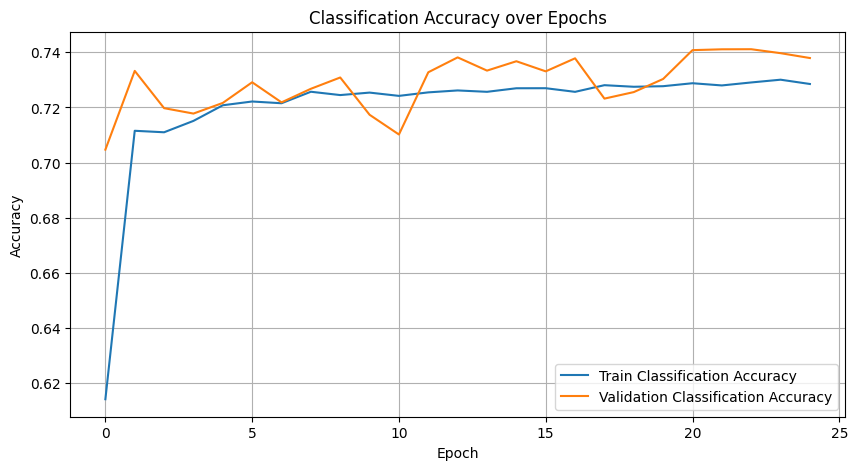

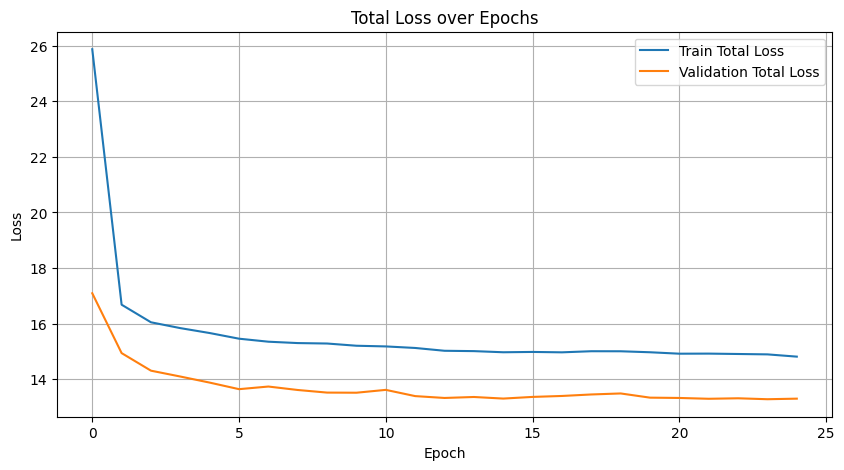

In [28]:
plt.figure(figsize=(10,5))
plt.plot(history.history['class_output_accuracy'], label='Train Classification Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

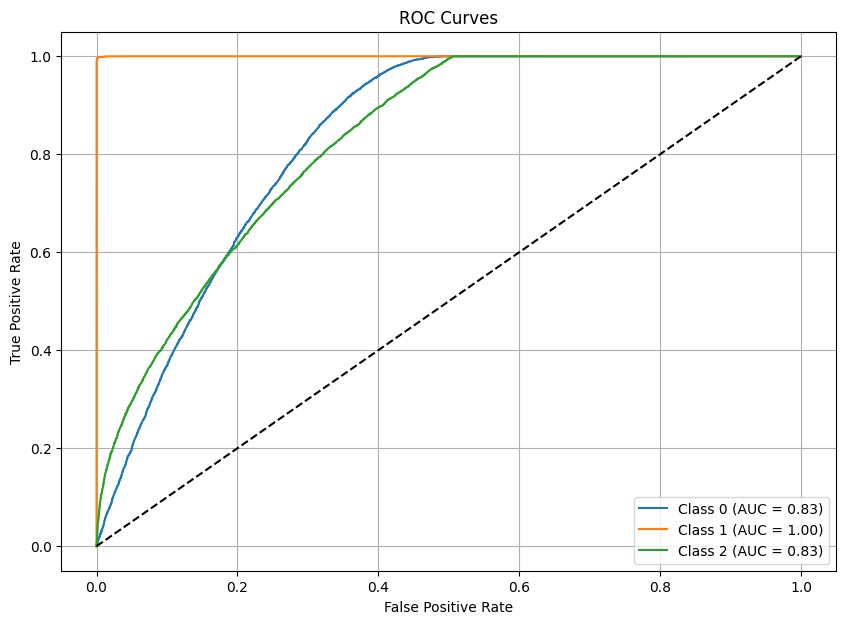

In [31]:
y_test_bin = tf.keras.utils.to_categorical(y_test_cls, num_classes=3)

plt.figure(figsize=(10,7))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_cls[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



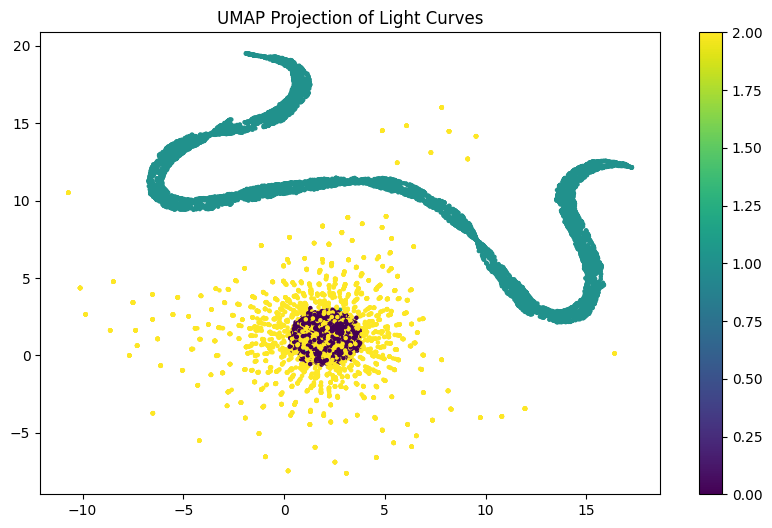

In [32]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test)

plt.figure(figsize=(10,6))
plt.scatter(embedding[:,0], embedding[:,1], c=y_test_cls, cmap='viridis', s=5)
plt.colorbar()
plt.title('UMAP Projection of Light Curves')
plt.show()

In [33]:
for i in range(5):
    print(f"Sample {i}: True Label = {y_test_cls[i]}, Predicted Label = {y_pred_labels[i]}")

Sample 0: True Label = 1, Predicted Label = 1
Sample 1: True Label = 1, Predicted Label = 1
Sample 2: True Label = 1, Predicted Label = 1
Sample 3: True Label = 2, Predicted Label = 2
Sample 4: True Label = 0, Predicted Label = 0


In [34]:
wrong_indices = np.where(y_test_cls != y_pred_labels)[0]
print(f"Total Wrong Predictions: {len(wrong_indices)}")
for i in wrong_indices[:5]:
    print(f"Sample {i}: True = {y_test_cls[i]}, Predicted = {y_pred_labels[i]}")

Total Wrong Predictions: 7809
Sample 7: True = 2, Predicted = 0
Sample 10: True = 2, Predicted = 0
Sample 11: True = 1, Predicted = 2
Sample 13: True = 2, Predicted = 0
Sample 14: True = 1, Predicted = 2


In [14]:
star_radius_au = 0.00465
planet_radius_au = 0.0000435
orbit_radius_au = 0.05
orbital_period_days = 10
num_points = 300
inclination_deg = 90

theta = np.linspace(0, 2 * np.pi, num_points)
x = orbit_radius_au * np.cos(theta)
y = orbit_radius_au * np.sin(theta) * np.cos(np.radians(inclination_deg))
z = orbit_radius_au * np.sin(theta) * np.sin(np.radians(inclination_deg))

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(size=100, color='yellow', opacity=0.8),
    name='Star'
))

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='lightblue', width=2),
    name='Orbit Path'
))

planet_trace = go.Scatter3d(
    x=[x[0]], y=[y[0]], z=[z[0]],
    mode='markers',
    marker=dict(size=6, color='red'),
    name='Planet'
)
fig.add_trace(planet_trace)

frames = []
for i in range(num_points):
    frames.append(go.Frame(data=[
        go.Scatter3d(x=[0], y=[0], z=[0], marker=dict(size=100, color='yellow', opacity=0.8)),
        go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='lightblue', width=2)),
        go.Scatter3d(x=[x[i]], y=[y[i]], z=[z[i]], marker=dict(size=6, color='red'))
    ], name=f"frame_{i}"))

fig.frames = frames

fig.update_layout(
    title="3D Exoplanet Transit Simulation",
    scene=dict(
        xaxis_title="X (AU)",
        yaxis_title="Y (AU)",
        zaxis_title="Z (AU)",
        aspectmode="cube"
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    height=600,
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[
            dict(label="Play", method="animate", args=[None, {"frame": {"duration": 50, "redraw": True}, "fromcurrent": True}]),
            dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "fromcurrent": True}])
        ]
    )]
)

fig.show()

In [15]:
def focal_loss_fixed(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

full_data = pd.read_csv('generated_light_curves.csv')

model = tf.keras.models.load_model('exoplanet_transformer_model.keras', custom_objects={'focal_loss_fixed': focal_loss_fixed})

with open('flux_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def get_verified_sample(label, prediction, seed):
    data = full_data[full_data['class'] == label]
    np.random.seed(seed)
    for idx in np.random.permutation(len(data)):
        sample = data.iloc[[idx]].drop(columns=['class', 'radius', 'duration', 'period'])
        pred = np.argmax(model.predict(scaler.transform(sample), verbose=0)[0])
        if pred == prediction:
            return sample

samples = {
    'example_curve_transit_1.csv': get_verified_sample(1, 1, 42),
    'example_curve_transit_2.csv': get_verified_sample(1, 1, 43),
    'example_curve_no_transit.csv': get_verified_sample(0, 0, 44),
    'example_curve_false_positive.csv': get_verified_sample(2, 2, 45)
}

for filename, sample in samples.items():
    if sample is not None:
        sample.to_csv(filename, index=False)

print("Example curves saved successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 44 variables whereas the saved optimizer has 86 variables. 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



Example curves saved successfully!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [16]:
X_baseline = full_data.drop(columns=['class', 'radius', 'duration', 'period']).values
y_baseline = full_data['class'].values

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_baseline, y_baseline, test_size=0.2, stratify=y_baseline, random_state=42
)

scaler_baseline = StandardScaler()
X_train_base = scaler_baseline.fit_transform(X_train_base)
X_test_base = scaler_baseline.transform(X_test_base)

baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_base, y_train_base)

print("Baseline Logistic Regression model trained.")

Baseline Logistic Regression model trained.


In [17]:
with open('baseline_logistic_model.pkl', 'wb') as f:
    pickle.dump(baseline_model, f)

print("Baseline Logistic Regression model saved as 'baseline_logistic_model.pkl'.")

Baseline Logistic Regression model saved as 'baseline_logistic_model.pkl'.


Baseline Model Classification Report:
                precision    recall  f1-score   support

    No Transit       0.68      0.69      0.68     10020
       Transit       1.00      1.00      1.00     10026
False Positive       0.68      0.67      0.67      9954

      accuracy                           0.79     30000
     macro avg       0.79      0.79      0.79     30000
  weighted avg       0.79      0.79      0.79     30000



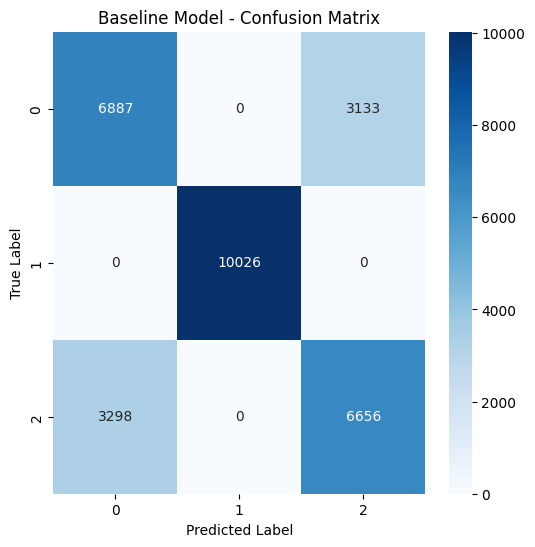

In [18]:
baseline_preds = baseline_model.predict(X_test_base)

print("Baseline Model Classification Report:")
print(classification_report(y_test_base, baseline_preds, target_names=["No Transit", "Transit", "False Positive"]))

cm_baseline = confusion_matrix(y_test_base, baseline_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline Model - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 44 variables whereas the saved optimizer has 86 variables. 



Transformer Model Classification Report:
                precision    recall  f1-score   support

    No Transit       0.61      0.62      0.62     10020
       Transit       1.00      0.99      1.00     10026
False Positive       0.61      0.60      0.61      9954

      accuracy                           0.74     30000
     macro avg       0.74      0.74      0.74     30000
  weighted avg       0.74      0.74      0.74     30000



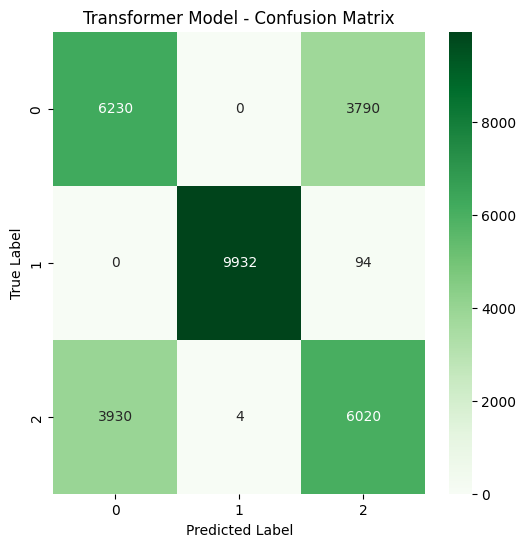

In [19]:
transformer_model = tf.keras.models.load_model(
    'exoplanet_transformer_model.keras',
    custom_objects={'focal_loss_fixed': focal_loss_fixed}
)

X = full_data.drop(columns=['class', 'radius', 'duration', 'period']).values
y = full_data['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler_trans = StandardScaler()
X_train = scaler_trans.fit_transform(X_train)
X_test = scaler_trans.transform(X_test)

predictions = transformer_model.predict(X_test, verbose=0)
y_pred = np.argmax(predictions[0], axis=1)

print("Transformer Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Transit", "Transit", "False Positive"]))

cm_transformer = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens')
plt.title('Transformer Model - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

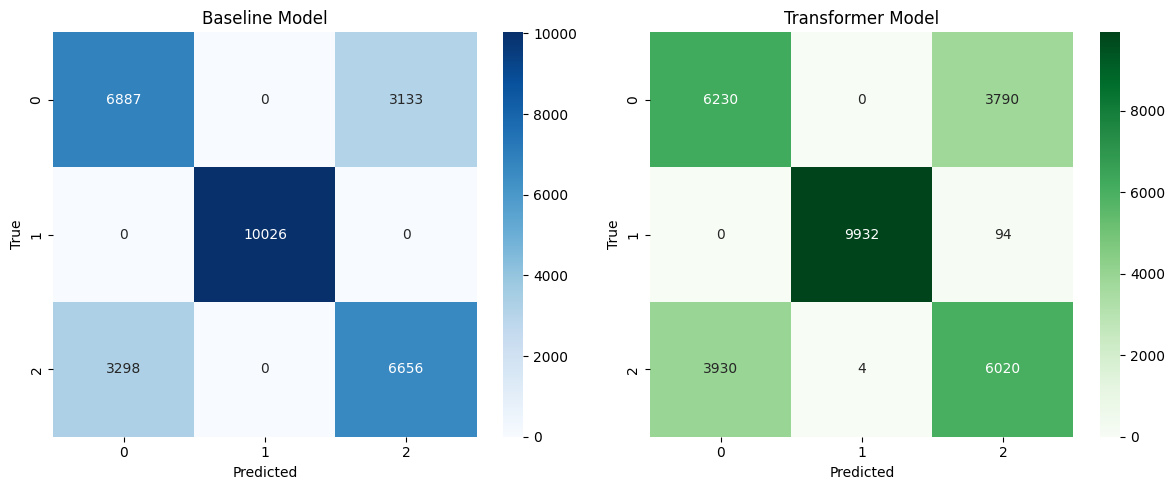

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Baseline Model')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title('Transformer Model')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [24]:
baseline_preds = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='macro')

transformer_preds_raw = transformer_model.predict(X_test, verbose=0)
transformer_preds = np.argmax(transformer_preds_raw[0], axis=1)
transformer_accuracy = accuracy_score(y_test, transformer_preds)
transformer_f1 = f1_score(y_test, transformer_preds, average='macro')

models = ['Baseline Logistic Regression', 'Transformer Encoder']
accuracies = [baseline_accuracy, transformer_accuracy]
f1_scores = [baseline_f1, transformer_f1]

for model_name, acc, f1 in zip(models, accuracies, f1_scores):
    print(f"{model_name}:")
    print(f"  - Accuracy: {acc*100:.2f}%")
    print(f"  - F1 Score (Macro Avg): {f1:.4f}")
    print()

Baseline Logistic Regression:
  - Accuracy: 78.56%
  - F1 Score (Macro Avg): 0.7853

Transformer Encoder:
  - Accuracy: 73.94%
  - F1 Score (Macro Avg): 0.7396



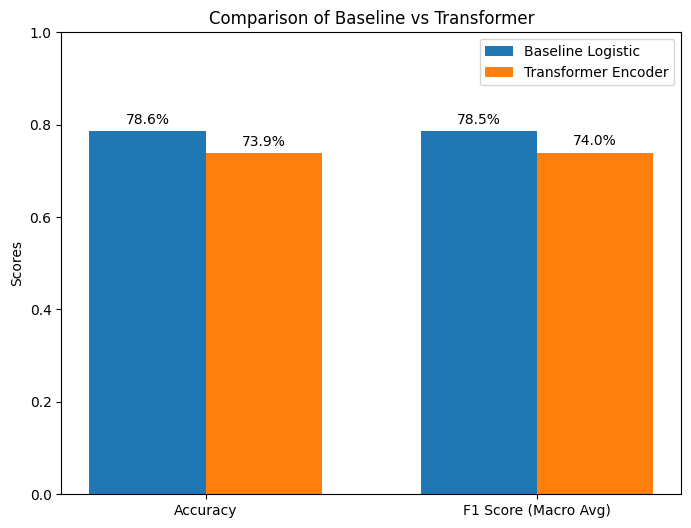

In [25]:
metrics = ['Accuracy', 'F1 Score (Macro Avg)']
baseline_scores = [baseline_accuracy, baseline_f1]
transformer_scores = [transformer_accuracy, transformer_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline Logistic')
rects2 = ax.bar(x + width/2, transformer_scores, width, label='Transformer Encoder')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Baseline vs Transformer')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.ylim(0,1)
plt.show()

In [ ]:
model = tf.keras.models.load_model('exoplanet_transformer_model.keras', compile=False)
with open('flux_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

class_mapping = {0: "No Transit", 1: "Transit", 2: "False Positive"}

def predict_light_curve(file):
    try:
        df = pd.read_csv(file.name)
        if df.shape[1] != 1000:
            return {"Error": "Uploaded file must have exactly 1000 flux columns."}, None

        X_infer = df.values
        X_scaled = scaler.transform(X_infer)
        preds = model.predict(X_scaled)

        class_probs = preds[0][0]
        radius_pred = preds[1][0][0]
        duration_pred = preds[2][0][0]
        period_pred = preds[3][0][0]

        class_idx = np.argmax(class_probs)
        predicted_class = class_mapping[class_idx]
        confidence = round(class_probs[class_idx] * 100, 2)

        output = {
            "Predicted Class": predicted_class,
            "Confidence (%)": confidence,
            "Predicted Radius (Relative to Star)": round(radius_pred, 4),
            "Predicted Duration (hours)": round(duration_pred, 4),
            "Predicted Orbital Period (days)": round(period_pred, 4)
        }

        if predicted_class == "Transit":
            fig = create_3d_plot(radius_pred, period_pred)
        else:
            fig = go.Figure()
            fig.update_layout(title="No 3D Plot for Non-Transit Cases", template="plotly_white")

        return output, fig

    except Exception as e:
        return {"Error": str(e)}, None

def create_3d_plot(planet_radius_rel_star, orbital_period_days):
    star_radius_au = 0.00465
    orbit_radius_au = 0.05
    num_points = 300

    theta = np.linspace(0, 2 * np.pi, num_points)
    x = orbit_radius_au * np.cos(theta)
    y = orbit_radius_au * np.sin(theta)
    z = np.zeros_like(theta)

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0], marker=dict(size=40, color='yellow', opacity=0.8), name='Star'))
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='lightblue', width=2), name='Orbit Path'))
    fig.add_trace(go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]], marker=dict(size=6, color='red'), name='Planet'))

    frames = []
    for i in range(num_points):
        frames.append(go.Frame(data=[
            go.Scatter3d(x=[0], y=[0], z=[0], marker=dict(size=40, color='yellow', opacity=0.8)),
            go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='lightblue', width=2)),
            go.Scatter3d(x=[x[i]], y=[y[i]], z=[z[i]], marker=dict(size=6, color='red'))
        ], name=f"frame_{i}"))

    fig.frames = frames
    fig.update_layout(
        title="3D Exoplanet Transit Simulation",
        scene=dict(aspectmode='cube', xaxis_title='X (AU)', yaxis_title='Y (AU)', zaxis_title='Z (AU)'),
        margin=dict(l=0, r=0, b=0, t=40),
        height=600,
        updatemenus=[dict(type="buttons", showactive=False, buttons=[
            dict(label="Play", method="animate", args=[None, {"frame": {"duration": 50, "redraw": True}, "fromcurrent": True}]),
            dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "fromcurrent": True}])
        ])]
    )

    return fig

examples=[
    ["example_curve_transit_1.csv"],
    ["example_curve_transit_2.csv"],
    ["example_curve_no_transit.csv"],
    ["example_curve_false_positive.csv"]
]

iface = gr.Interface(
    fn=predict_light_curve,
    inputs=gr.File(label="Upload Light Curve CSV (1000 flux points)"),
    outputs=[
        gr.JSON(label="Prediction and Confidence"),
        gr.Plot(label="3D Orbit Simulation")
    ],
    examples=examples,
    title="\U0001F680 Exoplanet Transit Detector",
    description="Upload a CSV (1000 flux points) to classify as Transit, No Transit, or False Positive and view 3D orbit based on predictions."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fcfbbb917bb18847ad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
